# Image Super Resolution train by GAN

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import glob
import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
images = sorted(glob.glob("anime_image/*.png"))
print(len(images)) #データサイズ

21551


## データの中身の確認

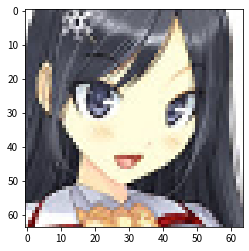

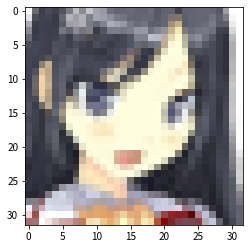

In [3]:
image_num = random.randint(0, len(images)-1)
img = Image.open(images[image_num])
img_resize = img.resize((img.width // 2, img.height // 2))
img_array = np.asarray(img)
img_resize_array = np.asarray(img_resize)
plt.imshow(img_array)
plt.show()
plt.imshow(img_resize_array)
plt.show()

In [4]:
HQ_images = []
LQ_images = []
for fname in tqdm.tqdm(images):
    img = Image.open(fname)
    img_array = np.asarray(img)
    low_quality_img = img.resize((img.width // 2, img.height // 2))
    low_quality_img_array = np.asarray(low_quality_img)
     #正規化
    img_array = img_array / 255 * 2 - 1
    low_quality_img_array = low_quality_img_array / 255 * 2 - 1
    HQ_images.append(img_array.transpose(2, 0, 1)) #(3, 32, 32)に変換
    LQ_images.append(low_quality_img_array.transpose(2, 0, 1))

100%|██████████| 21551/21551 [00:08<00:00, 2655.84it/s]


## train, vaild, testに分割

In [5]:
N = len(HQ_images)
x_train = LQ_images[ : int(N*0.8)]
y_train = HQ_images[ : int(N*0.8)]
x_valid = LQ_images[int(N*0.8) : int(N*0.9)]
y_valid = HQ_images[int(N*0.8) : int(N*0.9)]
x_test = LQ_images[int(N*0.9) : ]
y_test = HQ_images[int(N*0.9) : ]

In [6]:
x_train[0].shape

(3, 32, 32)

## dataloader

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class ImageDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # 入力 (3, 32, 32)
        self.t = Y # 出力 (3, 64, 64)

    def __len__(self):
        return len(self.t) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        #mtzk: 取り出すタイミングでひとつずつ torch.tensor にする
        #return self.X[index].to(device), self.t[index].to(device)
        return (torch.tensor(self.X[index]).float().to(device), 
                torch.tensor(self.t[index]).float().to(device))

In [8]:
train_dataset = ImageDataset(x_train, y_train)
valid_dataset = ImageDataset(x_valid, y_valid)

In [9]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## モデルの定義

In [10]:
# カスタムの重み初期化用関数。netGとnetDで呼び出される
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [11]:
class Generator(nn.Module):
    def __init__(self, in_dim=3, layers=8, channels=512, kernel_size=5, dropout=0.5, out_dim=256, speaker_num=100):
        super().__init__()
        generator = nn.ModuleList()
        for layer in range(layers):
            in_channels = in_dim if layer == 0 else channels
            out_channels = channels #512
            generator += [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2, bias=False),
                nn.BatchNorm2d(out_channels),
            ]
            if layer != layers - 1:
                generator += [nn.LeakyReLU(0.2, inplace=True)]
                generator += [nn.Dropout(dropout)]
        generator += [nn.ConvTranspose2d(out_channels, 3, 4, 2, 1, bias=False)]
        generator += [nn.Tanh()]
        self.generator = nn.Sequential(*generator)
        
    def forward(self, x): #x:メルスペクトログラム
        #x = torch.transpose(x, 3, 1, 2)
        out = self.generator(x)
        return out
        

In [12]:
#入力
x = torch.tensor(x_train[0]).float()
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 32, 32])

In [13]:
#出力
netG = Generator()
out = netG(x)
print(out.shape)

torch.Size([1, 3, 64, 64])


### Discriminator

In [14]:
ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 入力は (NC) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        out = self.main(input)
        return out

In [15]:
discriminator = Discriminator()
pred = discriminator(out)
pred.shape

torch.Size([1, 1, 1, 1])

In [16]:
# 生成器のインスタンス化
netG = Generator().to(device)

# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netG.apply(weights_init)

# モデルをprint出力する
print(netG)

Generator(
  (generator): Sequential(
    (0): Conv2d(3, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

In [17]:
# 識別器のインスタンス化
netD = Discriminator().to(device)
    
# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netD.apply(weights_init)

# モデルをprint出力する
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 学習

In [18]:
# dataloaderのワーカー数
workers = 2

# 訓練中のバッチサイズ
batch_size = 128

# 訓練画像の高さと幅のサイズ
# 全ての画像は変換器を使ってこのサイズにリサイズされます。
image_size = 64

# 識別器を伝播する特徴量マップのサイズ
ndf = 64

# 訓練エポック数
num_epochs = 20

# オプティマイザの学習率
lr = 0.0002

# オプティマイザ：Adamのハイパーパラメータ Beta1の値
beta1 = 0.5

In [19]:
# BCELoss関数の初期化
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

# 訓練中に利用する本物と偽物のラベルを設定
real_label = 1.
fake_label = 0.

# GとDの両方にオプティマイザ：Adamを設定する
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
# 訓練の進捗状況を把握するためのリスト
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 各エポックについて
for epoch in range(num_epochs):
    # dataloader内の各バッチについて
    for i, (X, y) in enumerate(train_dataloader, 0):
        
        ############################
        #  (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        ## 本物画像のバッチを使った訓練
        netD.zero_grad()
        # バッチの形式をランタイムに合わせる
        label = torch.ones((X.shape[0])).to(device)
        # 本物画像のバッチをDに順伝播させる
        output = netD(y).view(-1)
        # 全ての本物画像のバッチの損失を計算する
        errD_real = bce_loss(output, label)
        # 逆伝播で勾配を計算する
        errD_real.backward()
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        # 潜在ベクトルのバッチを生成
        # Gを使って、偽画像のバッチを生成
        fake = netG(X)
        label = torch.zeros((X.shape[0])).to(device)
        # Dを使って、全ての偽画像を分類
        output = netD(fake.detach()).view(-1)
        # 全ての偽画像に対するDの損失を計算
        errD_fake = bce_loss(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.ones((X.shape[0])).to(device) #Dが間違えたら損失が減るように
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        output = netD(fake).view(-1)
        # この出力に対するGの損失をもう一度計算
        bce = bce_loss(output, label)
        mse = mse_loss(fake, y)
        errG = bce*0.2 + mse
        # Gの勾配を計算
        errG.backward()
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), bce.item(), D_x, D_G_z1, D_G_z2))
        
        # あとでプロットするために損失を保存
        G_losses.append(bce.item())
        D_losses.append(errD.item())
        
        # 生成器Gの出力をfixed_noiseに保存して、生成器の動作を確認
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(X).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/20][0/135]	Loss_D: 1.9229	Loss_G: 3.0134	D(x): 0.7104	D(G(z)): 0.7148 / 0.0680
[0/20][50/135]	Loss_D: 0.4919	Loss_G: 2.5317	D(x): 0.7701	D(G(z)): 0.0915 / 0.1495
[0/20][100/135]	Loss_D: 0.5406	Loss_G: 5.8018	D(x): 0.6985	D(G(z)): 0.0067 / 0.0127
[1/20][0/135]	Loss_D: 0.3176	Loss_G: 1.7681	D(x): 0.8368	D(G(z)): 0.0721 / 0.2673
[1/20][50/135]	Loss_D: 0.3932	Loss_G: 3.2837	D(x): 0.8222	D(G(z)): 0.1149 / 0.0678
[1/20][100/135]	Loss_D: 1.0369	Loss_G: 4.6932	D(x): 0.9205	D(G(z)): 0.5280 / 0.0166
[2/20][0/135]	Loss_D: 0.8965	Loss_G: 2.8706	D(x): 0.5456	D(G(z)): 0.0744 / 0.1143
[2/20][50/135]	Loss_D: 0.7118	Loss_G: 3.3160	D(x): 0.8313	D(G(z)): 0.3056 / 0.0736
[2/20][100/135]	Loss_D: 0.6762	Loss_G: 3.2895	D(x): 0.7552	D(G(z)): 0.2304 / 0.0708
[3/20][0/135]	Loss_D: 0.8622	Loss_G: 3.8186	D(x): 0.7834	D(G(z)): 0.3730 / 0.0418
[3/20][50/135]	Loss_D: 0.8749	Loss_G: 4.4041	D(x): 0.8633	D(G(z)): 0.4296 / 0.0292
[3/20][100/135]	Loss_D: 1.0318	Loss_G: 1.8761	D(x): 0.4781	D(G

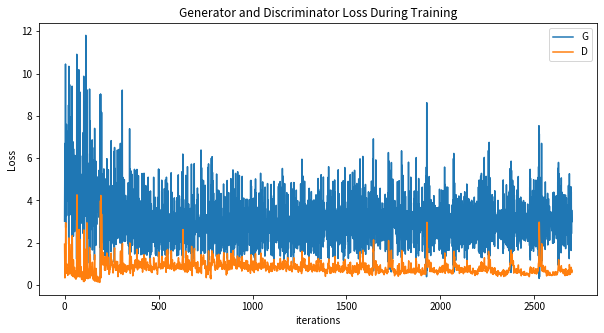

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

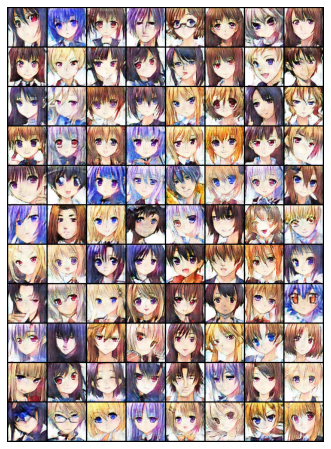

In [22]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [97]:
## 重みの保存

In [31]:
model_path = 'image_SR.pth'
torch.save(netG.state_dict(), model_path)

## テストデータの予測結果

In [34]:
model_path = 'image_SR.pth'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netG = Generator().to(device)
netG.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
netG.eval()

Generator(
  (generator): Sequential(
    (0): Conv2d(3, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1032


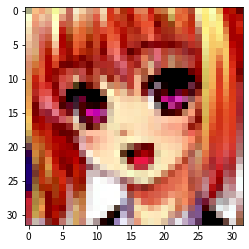

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


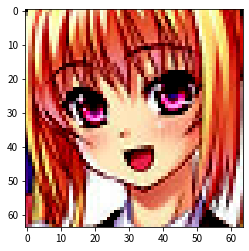

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


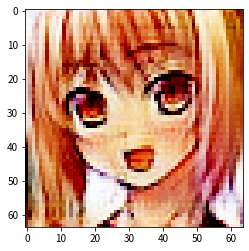

In [108]:
#予測
data_num = random.randint(0, len(x_test)-1)
print(data_num)
input_X = x_test[data_num].transpose(1, 2, 0)
X = torch.tensor(x_test[data_num]).float().to(device)
y = y_test[data_num].transpose(1, 2, 0)
X = X.unsqueeze(0)
#netG.eval()
pred = netG(X)
pred = pred.squeeze().to('cpu')
pred = pred.detach().numpy().transpose(1, 2, 0)

#画像の表示
plt.imshow(input_X)
plt.show()
plt.imshow(y)
plt.show()
plt.imshow(pred)
plt.show()